In [48]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [49]:
data = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv")
print (data.columns)


Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note',
       'ingressi_terapia_intensiva', 'note_test', 'note_casi',
       'totale_positivi_test_molecolare',
       'totale_positivi_test_antigenico_rapido', 'tamponi_test_molecolare',
       'tamponi_test_antigenico_rapido'],
      dtype='object')


In [50]:
data['diff_deceduti'] = data['deceduti'].diff()
data['diff_tamponi'] = data['tamponi'].diff()
dates = data['data']
date_format = [pd.to_datetime(d) for d in dates]

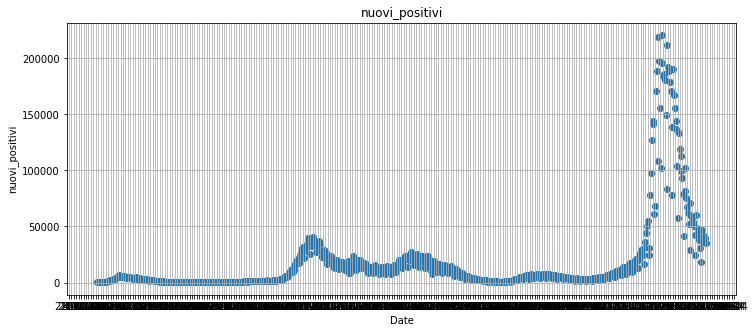

In [51]:
variable = 'nuovi_positivi'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
fig.savefig(variable + '.png')
plt.show()

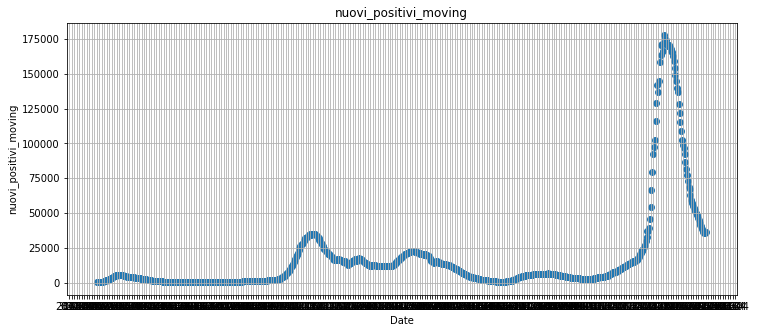

In [52]:
rolling_average_days = 7
data['nuovi_positivi_moving'] = data['nuovi_positivi'].rolling(window=rolling_average_days).mean()
variable = 'nuovi_positivi_moving'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
fig.savefig(variable + '.png')
plt.show()

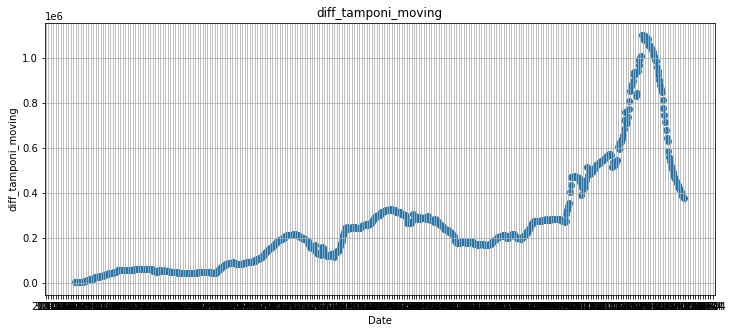

In [53]:
data['diff_tamponi_moving'] = data['tamponi'].diff().rolling(window=rolling_average_days).mean()

variable = 'diff_tamponi_moving'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
fig.savefig(variable + '.png')
plt.show()

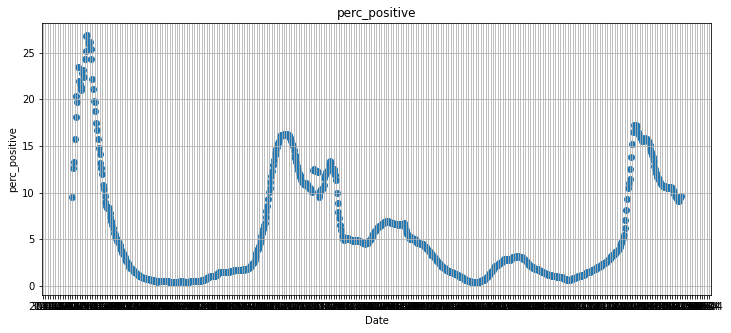

In [54]:
data['perc_positive'] = ((data['nuovi_positivi_moving'])/(data['diff_tamponi_moving'])*100)
variable = 'perc_positive'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
fig.savefig(variable + '.png')
plt.show()

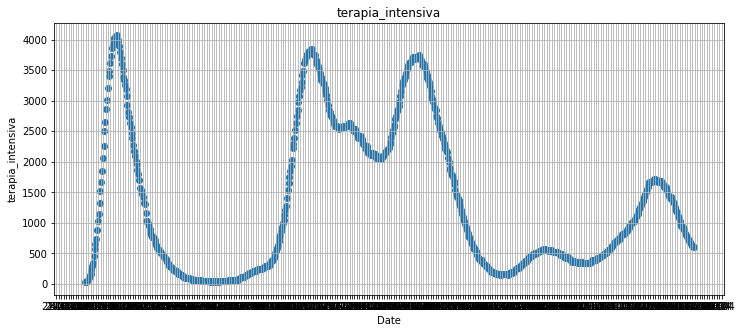

In [55]:
variable = 'terapia_intensiva'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
fig.savefig(variable + '.png')
plt.show()

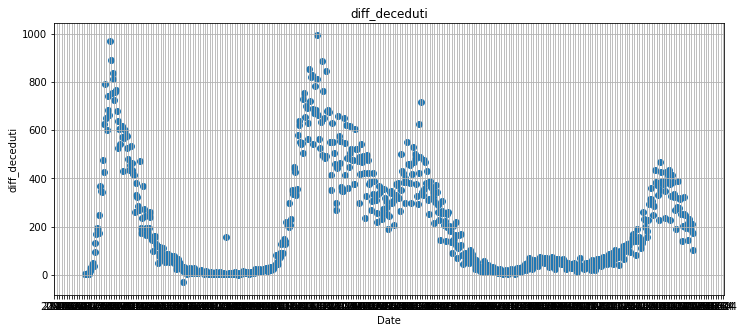

In [56]:
variable = 'diff_deceduti'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
fig.savefig(variable + '.png')
plt.show()

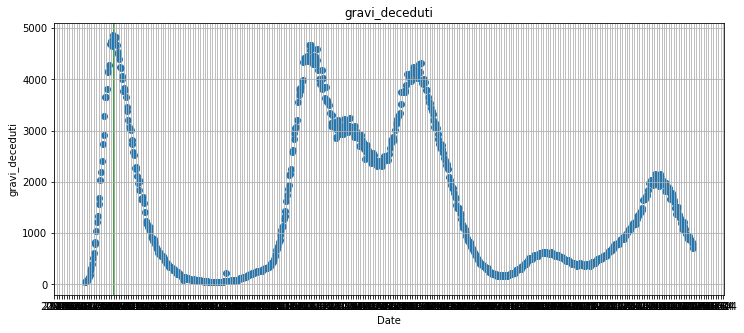

In [57]:
data['gravi_deceduti'] = data['diff_deceduti'] + data['terapia_intensiva']
variable = 'gravi_deceduti'
fig, ax = plt.subplots(figsize=(12, 5))
ax.grid()
ax.scatter(date_format,data[variable])
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
ax.axvline(datetime(2020, 4, 1), c="green", zorder=0)
fig.savefig(variable + '.png')
plt.show()

In [85]:
import numpy as np
from sklearn import linear_model
# prepare the lists for the model
X = date_format
y = data['gravi_deceduti'].tolist()[1:]
# date format is not suitable for modeling, let's transform the date into incrementals number starting from April 1st
starting_date = 700  # April 1st is the 37th day of the series
day_numbers = []
for i in range(1, len(X)):
    day_numbers.append([i])
X = day_numbers
# # let's train our model only with data after the peak
X = X[starting_date:]
y = y[starting_date:]
# Instantiate Linear Regression
linear_regr = linear_model.LinearRegression()
# Train the model using the training sets
linear_regr.fit(X, y)
print ("Linear Regression Model Score: %s" % (linear_regr.score(X, y)))

Linear Regression Model Score: 0.978229441934079


In [86]:
# Predict future trend
from sklearn.metrics import max_error
import math
y_pred = linear_regr.predict(X)
error = max_error(y, y_pred)

In [89]:
X_test = []
future_days = 750
for i in range(starting_date, starting_date + future_days):
    X_test.append([i])
y_pred_linear = linear_regr.predict(X_test)

In [90]:
y_pred_max = []
y_pred_min = []
for i in range(0, len(y_pred_linear)):
    y_pred_max.append(y_pred_linear[i] + error)
    y_pred_min.append(y_pred_linear[i] - error)

In [91]:
# convert date of the epidemic peak into datetime format
from datetime import datetime, timedelta
date_zero = datetime.strptime(data['data'][starting_date], '%Y-%m-%dT%H:%M:%S')
# creating x_ticks for making the plot more appealing
date_prev = []
x_ticks = []
step = 5
data_curr = date_zero
x_current = starting_date
n = int(future_days / step)
for i in range(0, n):
    date_prev.append(str(data_curr.day) + "/" + str(data_curr.month))
    x_ticks.append(x_current)
    data_curr = data_curr + timedelta(days=step)
    x_current = x_current + step

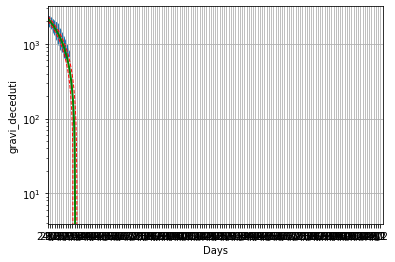

In [92]:
# plot known data
plt.grid()
plt.scatter(X, y)
# plot linear regression prediction
plt.plot(X_test, y_pred_linear, color='green', linewidth=2)
# plot maximum error
plt.plot(X_test, y_pred_max, color='red', linewidth=1, linestyle='dashed')
#plot minimum error
plt.plot(X_test, y_pred_min, color='red', linewidth=1, linestyle='dashed')
plt.xlabel('Days')
plt.xlim(starting_date, starting_date + future_days)
plt.xticks(x_ticks, date_prev)
plt.ylabel('gravi_deceduti')
plt.yscale("log")
plt.savefig("prediction.png")
plt.show()